# DS4A: MinJusticia
## Reducing the recidivim risk for people released from jail between 2010 and 2019 <br> 

**Team 77** <br>
**Members:** Sergio Bernal, Wilfer Carvajal , Diego Costa, Laura Goyeneche, Esneyder Guerrero, Daniel Hoyos, Katerin Lopez <br>
**Date:** July, 2020 

## Context

The Ministry of Justice leads the development of public policies that guarantee the effective protection of the rights of their citizens. Currently, the penitentiary and prison entities are interested in characterizing the jail population in Colombia and their recidivism risk to ensure an adequate formulation and monitoring of the criminal policy. <br><br>

## ML objective

Predict the risk of recidivism within X year(s) of their release date for individuals that had been in jail at least once. <br>
*This analysis corresponds to a first approach: we prodicted this risk within 1 year* 

## Basic

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix

%matplotlib inline
plt.style.use('seaborn')

In [2]:
# Import data
inmate = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

## Functions

In [3]:
# Featurization 

def reduce_cats(column, max_cat):
    cats = column.value_counts().index.tolist()
    new  = column.map(lambda x: x if x in cats[:max_cat] else 'OTHER')
    return new 

def dummy_helper(column):
    binary = preprocessing.LabelBinarizer()
    x      = column.fillna('MISSING').astype(str)
    temp   = binary.fit_transform(x.values)
    nmes   = [column.name + '_' + i for i in binary.classes_] if temp.shape[1] > 1 else [column.name]
    is_bin = temp.shape[1] == 2
    data   = pd.DataFrame(data = temp, columns = nmes)
    return data, is_bin
    
def binarize(data, column_nme):
    binarized = []
    for nme in column_nme:
        x, is_bin = dummy_helper(data[nme])
        if is_bin:
            data.loc[:,nme] = x
        else:
            data = pd.concat([data, x], axis = 1)
        binarized += list(x.columns)
    return data, binarized

def missing_ind(data, nme_list):
    for nme in nme_list:
        nme_na = 'na_ind_' + nme
        data.loc[:,nme_na] = (data[nme].isnull()).astype(float)
    return data

In [4]:
# Generate features (X)

def recidivism_days(booking, release):
    recidivism = booking.shift() - release
    recidivism = recidivism.values.astype('timedelta64(D)').astype(float)
    return recidivism 

In [5]:
# Generate outcome variable: 
# Individuals that came back to jail in a year 

def outcome(x_recidivism, max_time):
    outcome = (x_recidivism <= max_time*30).astype(int)
    return outcome

In [6]:
# Evaluation 
# t: threshold 

def binprob(y_hat, t):
    threshold = np.sort(y_hat)[::-1][int(t*len(y_hat))]
    binary    = [1 if i >= threshold else 0 for i in y_hat]
    y_pred    = np.asarray(binary)
    return y_pred

def accuracy_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = accuracy_score(y, y_pred)
    return score 

def precision_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = precision_score(y, y_pred)
    return score 

def recall_t(y, y_hat, t):
    y_pred = binprob(y_hat, t)
    score  = recall_score(y, y_pred)
    return score

def plot_precision_recall(y, y_hat, title=None):

    precision_curve, recall_curve, pr_threshold = precision_recall_curve(y, y_hat)
    precision_curve = precision_curve[:-1]
    recall_curve    = recall_curve[:-1]
    
    above_threshold = []
    number_scored   = len(y_hat)
    
    for value in pr_threshold:
        num_above_thresh = len(y_hat[y_hat >= value])
        pct_above_thresh = num_above_thresh/float(number_scored)
        above_threshold.append(pct_above_thresh)
    
    above_threshold = np.array(above_threshold)
    
    fig, ax1 = plt.subplots()
    ax1.plot(above_threshold, precision_curve, 'b')
    ax1.set_xlabel('\nFraction of Population')
    ax1.set(ylim = (0, 1))

    ax1.set_ylabel('Precision\n', color = 'b')
    ax2 = ax1.twinx()
    ax1.plot(above_threshold, recall_curve, 'r')
    ax2.set_ylabel('Recall\n', color = 'r')
    
    if title is not None:
        plt.title(title + '\n')
    
    plt.show()

## Feature Engineering

In [7]:
# Feature changes
# Dates
inmate.FECHA_INGRESO = pd.to_datetime(inmate.FECHA_INGRESO)
inmate.FECHA_SALIDA  = pd.to_datetime(inmate.FECHA_SALIDA)
inmate.FECHA_CAPTURA = pd.to_datetime(inmate.FECHA_CAPTURA)

# Crime types
inmate.TENTATIVA  = inmate.TENTATIVA .apply(lambda x: 1 if x == 'S' else 0)
inmate.AGRAVADO   = inmate.AGRAVADO  .apply(lambda x: 1 if x == 'S' else 0)
inmate.CALIFICADO = inmate.CALIFICADO.apply(lambda x: 1 if x == 'S' else 0)

inmate.TENTATIVA  = inmate.TENTATIVA .apply(lambda x: 'TENT_' if x == 1 else '')
inmate.AGRAVADO   = inmate.AGRAVADO  .apply(lambda x: 'AGRA_' if x == 1 else '')
inmate.CALIFICADO = inmate.CALIFICADO.apply(lambda x: 'CALF_' if x == 1 else '')

# Activities
inmate.ACTIVIDADES_TRABAJO   = inmate.ACTIVIDADES_TRABAJO  .apply(lambda x: 1 if x == 'SI' else 0)
inmate.ACTIVIDADES_ESTUDIO   = inmate.ACTIVIDADES_ESTUDIO  .apply(lambda x: 1 if x == 'SI' else 0)
inmate.ACTIVIDADES_ENSEÑANZA = inmate.ACTIVIDADES_ENSEÑANZA.apply(lambda x: 1 if x == 'SI' else 0)

# Children: Y/N
inmate.HIJOS_MENORES = inmate.HIJOS_MENORES.apply(lambda x: 1 if x == 'SI' else 0)

# Genero
inmate.GENERO = inmate.GENERO.apply(lambda x: 1 if x == 'MASCULINO' else 0)

# Crime + crime type
inmate['DELITO_COMP'] = inmate.TENTATIVA + inmate.AGRAVADO + inmate.CALIFICADO + inmate.DELITO
inmate.DELITO_COMP    = reduce_cats(inmate.DELITO_COMP, 20)

# Country 
inmate.PAIS_INTERNO = reduce_cats(inmate.PAIS_INTERNO, 2)

In [8]:
# Select features of interest
inmate = inmate[['INTERNOEN',
                 'DELITO_COMP',
                 'FECHA_INGRESO','FECHA_SALIDA','FECHA_CAPTURA',
                 'ANO_NACIMIENTO','GENERO','ESTADO_CIVIL','NIVEL_EDUCATIVO','HIJOS_MENORES',
                 'PAIS_INTERNO',
                 'ESTADO_INGRESO',
                 'ACTIVIDADES_TRABAJO','ACTIVIDADES_ESTUDIO','ACTIVIDADES_ENSEÑANZA',
                 'DEPTO_ESTABLECIMIENTO','REGIONAL']]

In [9]:
# Intermediate table
iscat  = [nme for nme in inmate.columns[inmate.dtypes == 'object'] if nme != 'INTERNOEN']
inmate = binarize(inmate, iscat)[0]
inmate = inmate.drop(iscat, axis = 1)
inmate = inmate.drop(['FECHA_CAPTURA'], axis = 1)

In [10]:
# Time in jail 
inmate['timejail_day'] = (inmate.FECHA_SALIDA - inmate.FECHA_INGRESO)
inmate.timejail_day    = inmate.timejail_day.dt.days

## Master table

In [11]:
# Key: inmate + booking date
inmate_booking = inmate.copy().sort_values(by = ['INTERNOEN','FECHA_INGRESO'])\
                              .groupby(['INTERNOEN','FECHA_INGRESO'])\
                              .max()\
                              .reset_index()

In [12]:
# Recidivism in days and booking data t-1
inmate_booking['FECHA_SALIDA_t_1'] = inmate_booking.groupby('INTERNOEN').FECHA_SALIDA.shift(1)
inmate_booking['recidivism_day']   = (inmate_booking.FECHA_INGRESO - inmate_booking.FECHA_SALIDA_t_1).dt.days

In [13]:
# Year booking date 
inmate_booking['year'] = inmate_booking.FECHA_INGRESO.dt.year

## Handling NAs and errors

Below we can observe that there is a large number of observations without `time in jail` and `recidivism in days`. The main reason is that the ministry of Justice didn't gave the DS4A team access to data of the the first time in jail for all inmates between 2010 and 2019. As well, due to errors in the data, when comparing the release date in t-1 and booking date in t, we have negative values. For this reasons we decided that the best way to deal with NAs is to impute those values based on the distribution of the observables values. We argue that this is plausible given that the literature and the recidivism in other countries present the same trend as the one from our observable values, by imputing those values on the distribution. For negative values of `time in jail` and `recividism in days` we omit them.

In [14]:
# Identify NAs from our features of interest
print('Total inmates and booking date {}'.format(inmate_booking.shape[0]))
print('Time in jail in days NAs are {}'  .format(inmate_booking.timejail_day.isna().sum()))
print('Recidivism in days NAs are {}'    .format(inmate_booking.recidivism_day.isna().sum()))

Total inmates and booking date 103290
Time in jail in days NAs are 30304
Recidivism in days NAs are 78857


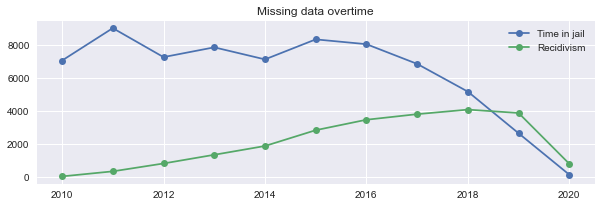

In [15]:
# Understand NAs overtime
# Time in jail and recidivism in days
plt.figure(figsize = (10,3))
plt.plot(inmate_booking[inmate_booking.timejail_day   > 0].groupby('year').count().INTERNOEN.to_frame().rename(columns = {'INTERNOEN':'NA_count'}), '-o', label = 'Time in jail')
plt.plot(inmate_booking[inmate_booking.recidivism_day > 0].groupby('year').count().INTERNOEN.to_frame().rename(columns = {'INTERNOEN':'NA_count'}), '-o', label = 'Recidivism')
plt.title('Missing data overtime')
plt.legend()
plt.show()

In [16]:
# Summary of statistics for time in jail and recividism 
stats = inmate_booking[(inmate_booking.recidivism_day > 0) & (inmate_booking.timejail_day > 0)][['recidivism_day','timejail_day']].describe()
stats

,recidivism_day,timejail_day
count,17263.000000,17263.000000
mean,758.160517,551.920640
std,599.162070,415.245575
min,1.000000,1.000000
25%,294.000000,246.000000
50%,605.000000,458.000000
75%,1085.000000,749.000000
max,5311.000000,2967.000000


In [17]:
# "Impute" recidivism
vmin = stats.recidivism_day['min']
vmax = stats.recidivism_day['max']
inmate_booking.recidivism_day = inmate_booking.recidivism_day.apply(lambda x: np.random.uniform(vmin,vmax) if np.isnan(x) else x)

In [18]:
# "Impute" time in jail
vmin = stats.timejail_day['min']
vmax = stats.timejail_day['max']
inmate_booking.timejail_day = inmate_booking.timejail_day.apply(lambda x: np.random.uniform(vmin,vmax) if np.isnan(x) else x)

In [19]:
# Identify negative values from our features of interest
print('Total inmates and booking date {}'   .format(inmate_booking.shape[0]))
print('Time in jail in days negative are {}'.format((inmate_booking.timejail_day < 0).sum()))
print('Recidivism in days negative are {}'  .format((inmate_booking.recidivism_day < 0).sum()))

Total inmates and booking date 103290
Time in jail in days negative are 3041
Recidivism in days negative are 849


In [20]:
# Delete negative values from time in jail and recidivism 
inmate_booking = inmate_booking[inmate_booking.timejail_day   >= 0] # omit 3041
inmate_booking = inmate_booking[inmate_booking.recidivism_day >= 0] # omit 841

In [21]:
# Final master table dimension 
print('Total inmates and booking date {}'.format(inmate_booking.shape[0]))

Total inmates and booking date 99447


In [22]:
# Additional columns with missing values
inmate_booking.columns[inmate_booking.isnull().any()].tolist()

['FECHA_SALIDA', 'FECHA_SALIDA_t_1']

## Modeling

### Training

In [23]:
# Split data based on time
train_start = 2010
train_end   = 2017
test_start  = 2018
test_end    = 2019

In [24]:
# Generate train and test data frames
dftrain = inmate_booking.copy()[(inmate_booking.year >= train_start) & (inmate_booking.year <= train_end)]
dftest  = inmate_booking.copy()[(inmate_booking.year >= test_start ) & (inmate_booking.year <= test_end )]

# Calculate age based on train and test end period
dftrain['age'] = train_end - dftrain.ANO_NACIMIENTO
dftest['age']  = test_end  - dftest .ANO_NACIMIENTO

# Calculate outcome variable = 1 if individual came to jail in less that a year
dftrain['outcome'] = (dftrain.recidivism_day <= 12*30).astype(int)
dftest['outcome']  = (dftest.recidivism_day  <= 12*30).astype(int)

In [25]:
# Number of individuals that came back to jail in less than a year
print('Train set: {} out of {} ~ {}%'.format(dftrain.outcome.sum(),dftrain.shape[0],round(dftrain.outcome.sum()*100/dftrain.shape[0])))
print('Test  set: {} out of {} ~ {}%'.format(dftest.outcome.sum(),dftest.shape[0],round(dftest.outcome.sum()*100/dftest.shape[0])))

Train set: 8540 out of 71359 ~ 12.0%
Test  set: 2957 out of 25013 ~ 12.0%


In [26]:
colnmes = dftrain.columns.drop(['ANO_NACIMIENTO','FECHA_SALIDA_t_1','FECHA_INGRESO','FECHA_SALIDA','INTERNOEN','year','recidivism_day','outcome']).tolist()

In [27]:
X_train, y_train = dftrain[colnmes], dftrain['outcome']
X_test , y_test  = dftest [colnmes], dftest ['outcome']

In [28]:
rfc = RandomForestClassifier(random_state = 42)

In [29]:
param_grid = {'n_estimators': [20, 50],
              #'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth'   : [4,5,6,7,8]
              #'criterion'   : ['gini', 'entropy']
             }

In [30]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [31]:
best_model = CV_rfc.best_estimator_

### Testing

In [32]:
y_true = y_test.values
y_pred = best_model.predict_proba(X_test)

In [37]:
# Tests metrics on 20% of the population
# Assumption: Ministry of Justica with limited resources to implement policies on 100% of the individuals
k = 0.2
print('Accuracy at 20% :', accuracy_t (y_test, y_pred[:,1], k))
print('Precision at 20%:', precision_t(y_test, y_pred[:,1], k))
print('Recall at 20%   :', recall_t   (y_test, y_pred[:,1], k))

Accuracy at 20% : 0.757965857753968
Precision at 20%: 0.19048570857485508
Recall at 20%   : 0.32228610077781533


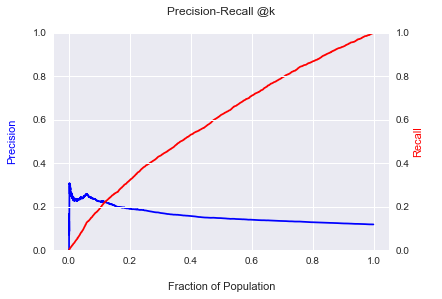

In [34]:
plot_precision_recall(y_test, y_pred[:,1], "Precision-Recall @k")

### Feature importance

In [35]:
important = best_model.feature_importances_
features  = X_train.columns
idxs      = np.argsort(important)[-20:]

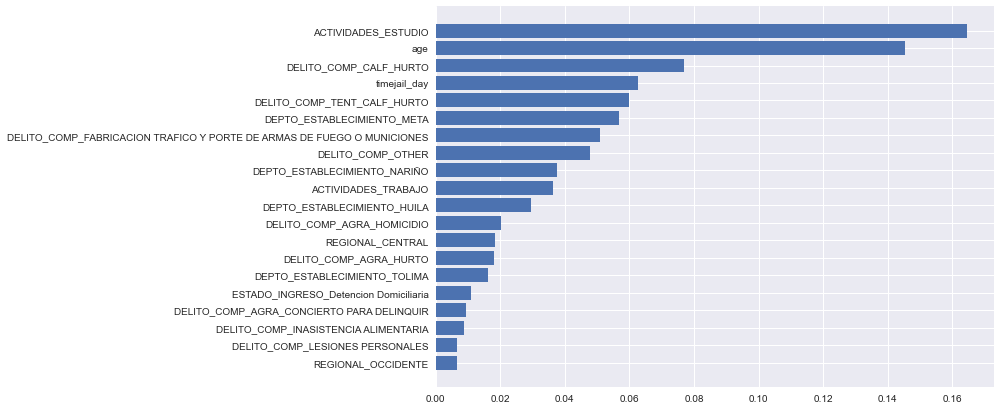

In [36]:
plt.figure(figsize = (10,7))
plt.barh(range(len(idxs)), important[idxs])
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.show()